# Data-pipeline simple example
Using syntethic data that's allready fairly clean, this is a showcase of some important operations.
For details about WTTE-RNN, 

In [1]:
#%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from six.moves import xrange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_rows = 10

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from wtte.data_generators import generate_random_df
import wtte.transforms as tr
import wtte.weibull as weibull
import wtte.wtte as wtte
from wtte.wtte import WeightWatcher
from wtte.plots.misc import timeline_aggregate_plot, timeline_plot

## Generating and mangling random data 
First, lets use a utility function to generate some data. The procedure to generate it is:
For every sequence:
1. generate a random seq_length from [1,`max_seq_length`]
2. generate the number of observations in the sequence from [1,seq_length]
3. randomly pick observation elapsed times from [1,`seq_length`]
4. randomly pick a starttime [0,`starttimes_max`]
5. Generate random data in the columns at these timesteps
This means that the only thing we know about a sequence is that it's at maximum `max_seq_length`

,id,dt,t_ix,t_elapsed,event,int_column,double_column
0,0,0,0,0,1,-4,0.317551
1,0,1,1,1,1,4,0.538804
2,0,2,2,2,1,-5,0.492728
3,0,3,3,3,1,4,0.179981
4,0,4,4,4,1,1,0.567079
...,...,...,...,...,...,...,...
51405,998,203,1,4,1,-5,0.794312
51406,998,204,2,5,1,1,0.478400
51407,999,199,0,0,1,0,0.738591
51408,999,220,1,21,1,1,0.493245


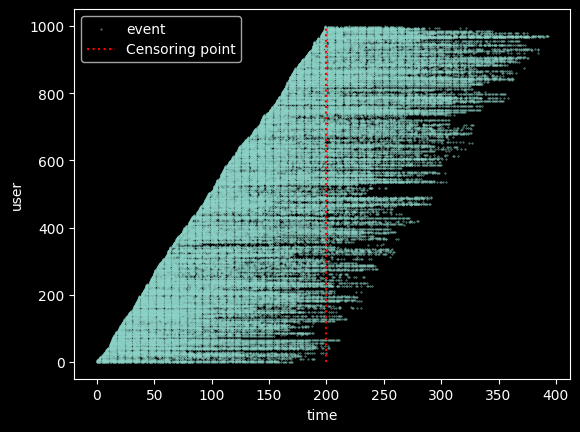

In [3]:
max_seq_length=200
starttimes_max=200
n_seqs=1000
df = generate_random_df(max_seq_length=max_seq_length, n_seqs=n_seqs,
                        starttimes_max=starttimes_max)
df.event = 1
plt.scatter(df.dt, df.id, 0.1, label='event')
plt.xlabel('time')
plt.ylabel('user')
censoring_point = starttimes_max
plt.vlines(x=censoring_point, ymin=0, ymax=n_seqs, color='red',
           linestyles='dotted', label='Censoring point')
plt.legend()
df

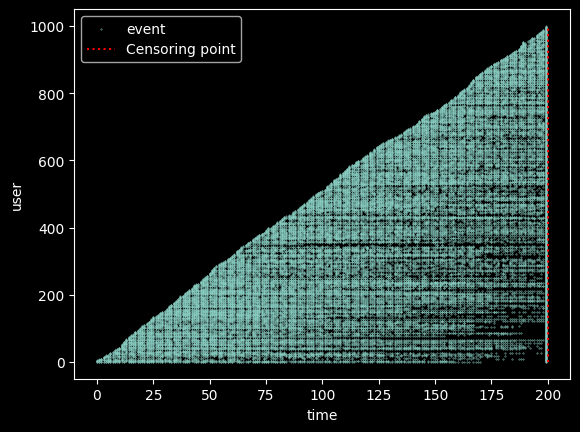

In [4]:
# Cut away what we imagine as the future:
df_subset = df[df.dt < censoring_point]
# And make sure that we - for each sequence - add a reminder of when this was 
# (i.e largest timestamp in dataset), assuming that we can't tell that sequences terminated.
df_subset = tr.df_join_in_endtime(df_subset, abs_time_col='dt', fill_zeros=True)
# As per the warning, recalculate 
df_subset['t_elapsed'] = df_subset.groupby('id', group_keys=False).apply(lambda g : g.dt - g.dt.min())
plt.scatter(df_subset.dt, df_subset.id, 0.1, label='event')
plt.xlabel('time')
plt.ylabel('user')
plt.vlines(x=censoring_point, ymin=0, ymax=len(df_subset.id.unique()),
           color='red', linestyles='dotted', label='Censoring point')
plt.legend()
plt.show()

## Data to tensor & split into test/train

/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/wtte/plots/misc.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(None, None)

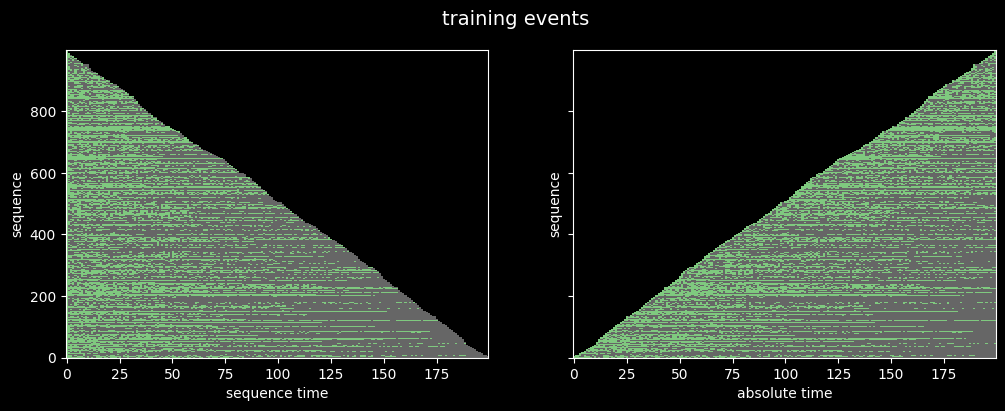

In [5]:
events_train  = tr.df_to_padded(df=df_subset, column_names=['event'], t_col='t_elapsed')
x_train = tr.df_to_padded(df=df_subset, column_names=['event', 'double_column'], t_col='t_elapsed')
# As validation data pick the continuation of the sequence. 
m = df.id <= df_subset.id.max()
events_test  = tr.df_to_padded(df=df[m], column_names=['event'], t_col='t_elapsed')
x_test = tr.df_to_padded(df=df[m], column_names=['event', 'double_column'], t_col='t_elapsed')
timeline_plot(np.squeeze(events_train), 'training events', cmap='Accent_r')
#plt.show()
# print('Testing: (sequence terminated -> no censoring -> no rightzeropadding ->plot doesnt make sense)')
# timeline_plot(np.squeeze(events_test),'testing events',cmap='Accent_r');
# plt.show()

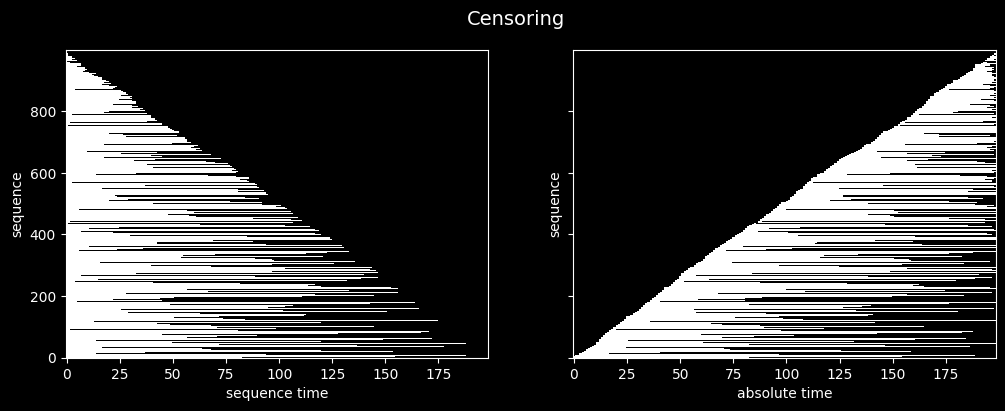

mean uncensored (train):  0.6421025328957213
mean uncensored (test) :  1.0
mean tte (test):          2.921946665584284
max  tte (test):          166.0


In [6]:
def prep_tensors(x, events):
    # 0. calculate time to event and censoring indicators.
    y  = np.copy(np.concatenate([events,events], -1))
    y[:,:,0] = tr.padded_events_to_tte(np.squeeze(events), discrete_time=True)
    y[:,:,1] = tr.padded_events_to_not_censored(np.squeeze(events), discrete_time=True)
    # 1. Disalign features and targets otherwise truth is leaked.
    # 2. drop first timestep (that we now dont have features for)
    # 3. nan-mask the last timestep of features. (that we now don't have targets for)
    events = events[:, 1:,]
    y  = y[:, 1:]
    x  = np.roll(x, shift=1, axis=1)[:, 1:,]
    x  = x + 0*events
    return x, y, events    
x_test, y_test, events_test = prep_tensors(x_test, events_test)
x_train, y_train, events_train = prep_tensors(x_train, events_train)
timeline_plot(1-y_train[:,:,1], 'Censoring', cmap='Greys')
plt.show()
print('mean uncensored (train): ',np.nanmean(y_train[:, :, 1]))
print('mean uncensored (test) : ',np.nanmean(y_test[:, :, 1]))
print('mean tte (test):         ',np.nanmean(y_test[:, :, 0]))
print('max  tte (test):         ',np.nanmax(y_test[:, :, 0]))

## WTTE RNN

In [7]:
def nanmask_to_keras_mask(x, y, mask_value, tte_mask):
    """nanmask to keras mask.
        :param float mask_value: Use some improbable telltale value (but not nan-causing)
        :param float tte_mask: something that wont NaN the loss-function
    """
    # Use some improbable telltale value (but not nan-causing)
    x[:,:,:][np.isnan(x)] = mask_value
    y[:,:,0][np.isnan(y[:,:,0])] = tte_mask
    y[:,:,1][np.isnan(y[:,:,1])] = 0.95
    sample_weights = (x[:,:,0] != mask_value)*1.
    return x, y, sample_weights

tte_mean_train = np.nanmean(y_train[:, :, 0])
mask_value = -1.3371337 
mean_u = np.nanmean(y_train[:, :, 1])
x_test,y_test,sample_weights_test = nanmask_to_keras_mask(x_test,y_test,mask_value,
                                                          tte_mean_train)
x_train,y_train,sample_weights_train = nanmask_to_keras_mask(x_train, y_train,
                                                             mask_value,tte_mean_train)
# Initialization value for alpha-bias 
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/mean_u
print('init_alpha: ', init_alpha, 'mean uncensored train: ', mean_u)

init_alpha:  30.12765800585112 mean uncensored train:  0.6421025328957213


In [8]:
import tensorflow.keras
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Masking, Lambda
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers.legacy import RMSprop, Adam
from tensorflow.keras import callbacks

reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', 
                                        factor  =0.5, 
                                        patience=50, 
                                        verbose=0, 
                                        mode='auto', 
                                        min_delta=0.0001, 
                                        cooldown=0, 
                                        min_lr=1e-8)
nanterminator = callbacks.TerminateOnNaN()
history = callbacks.History()
weightwatcher = WeightWatcher(per_batch=False, per_epoch=True)
n_features = x_train.shape[-1]
        
def base_model():
    model = Sequential()
    model.add(Masking(mask_value=mask_value, input_shape=(None, n_features)))
    model.add(GRU(3, activation='tanh', return_sequences=True))
    return model

def wtte_rnn():
    model = base_model()
    model.add(TimeDistributed(Dense(2)))
    model.add(Lambda(wtte.output_lambda, 
                     arguments={"init_alpha": init_alpha, 
                                "max_beta_value": 4.0,
                                "scalefactor": 0.5}))
    loss = wtte.loss(kind='discrete', reduce_loss=False).loss_function
    model.compile(loss=loss, optimizer=Adam(learning_rate=.01, clipvalue=0.5),
                  sample_weight_mode='temporal', weighted_metrics=[])
    return model

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-05 16:26:43.620801: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-05 16:26:43.620822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 2)           0         
                                                                 
 gru (GRU)                   (None, None, 3)           63        
                                                                 
 time_distributed (TimeDistr  (None, None, 2)          8         
 ibuted)                                                         
                                                                 
 lambda (Lambda)             (None, None, 2)           0         
                                                                 
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75


2023-02-05 16:26:48.175229: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-05 16:26:48.944609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-05 16:26:49.174103: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_18/output/_21'
2023-02-05 16:26:49.176837: I tensorflow/core/grappler/optimizers/custom_graph_optimiz

10/10 [==============================] - ETA: 0s - loss: 1.5103 

2023-02-05 16:29:02.311731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-05 16:29:02.431960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 140s 14s/step - loss: 1.5103 - val_loss: 1.7338 - lr: 0.0100
Epoch 2/75
10/10 [==============================] - 122s 14s/step - loss: 1.3247 - val_loss: 1.5572 - lr: 0.0100
Epoch 3/75
10/10 [==============================] - 123s 14s/step - loss: 1.1914 - val_loss: 1.4149 - lr: 0.0100
Epoch 4/75
10/10 [==============================] - 124s 14s/step - loss: 1.0926 - val_loss: 1.3039 - lr: 0.0100
Epoch 5/75
10/10 [==============================] - 1032s 113s/step - loss: 1.0251 - val_loss: 1.2341 - lr: 0.0100
Epoch 6/75
10/10 [==============================] - 502s 56s/step - loss: 0.9948 - val_loss: 1.1944 - lr: 0.0100
Epoch 7/75
10/10 [==============================] - 122s 12s/step - loss: 0.9661 - val_loss: 1.1749 - lr: 0.0100
Epoch 8/75
10/10 [==============================] - 107s 10s/step - loss: 0.9581 - val_loss: 1.1670 - lr: 0.0100
Epoch 9/75
10/10 [==============================] - 90s 10s/step - loss: 0.9548 - val_loss: 1.1633 - lr: 

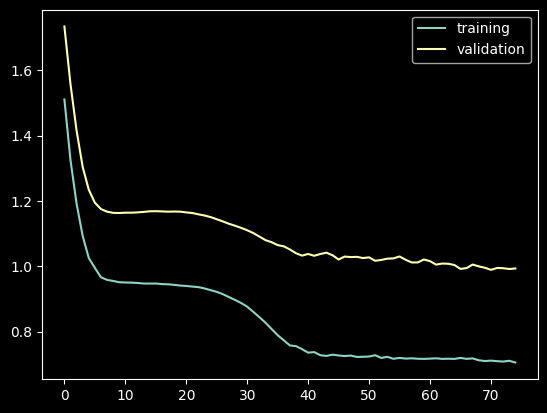

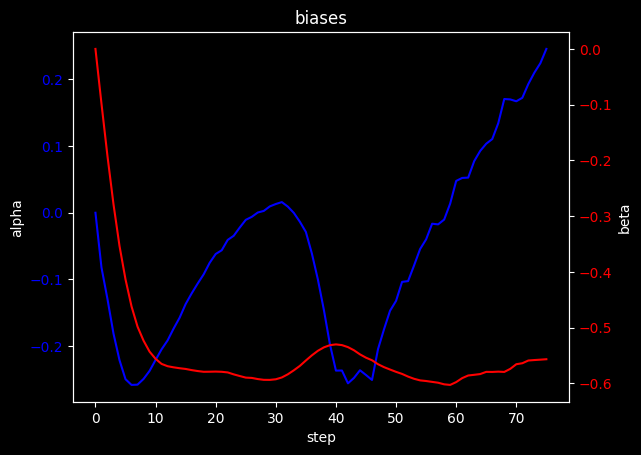

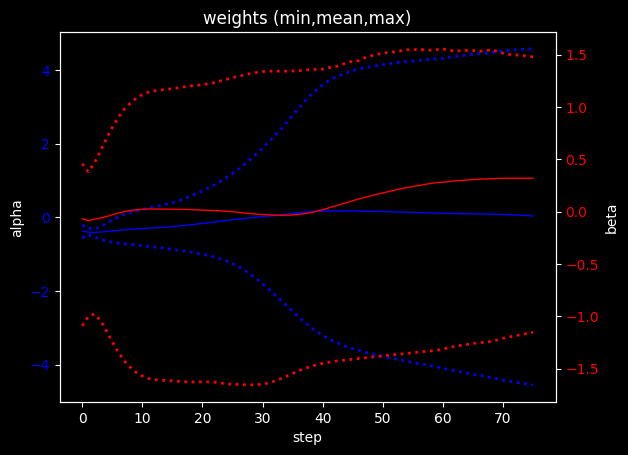

In [9]:
model = wtte_rnn()
model.summary()
k.set_value(model.optimizer.learning_rate, 0.01)
model.fit(x_train, y_train,
          epochs=75,
          batch_size=100, 
          verbose=1,
          validation_data=(x_test, y_test, sample_weights_test),
          sample_weight = sample_weights_train,          
          callbacks=[nanterminator, history, weightwatcher, reduce_lr])
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()
weightwatcher.plot()

2023-02-05 21:10:08.349734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-05 21:10:08.499555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 8s 123ms/step


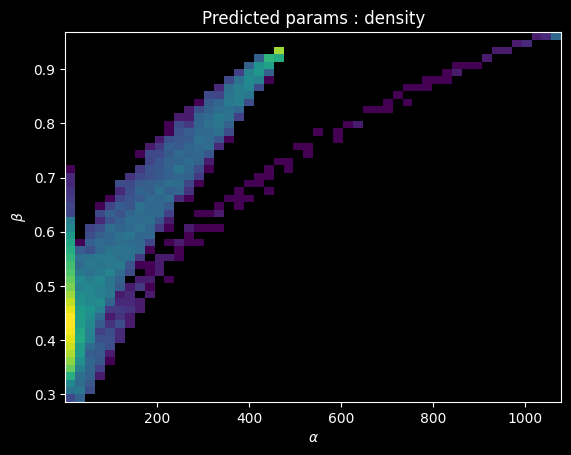

Bad Example?:


/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/wtte/weibull.py:71: RuntimeWarning: invalid value encountered in power
  mode = a * np.power((b - 1.0) / b, 1.0 / b)


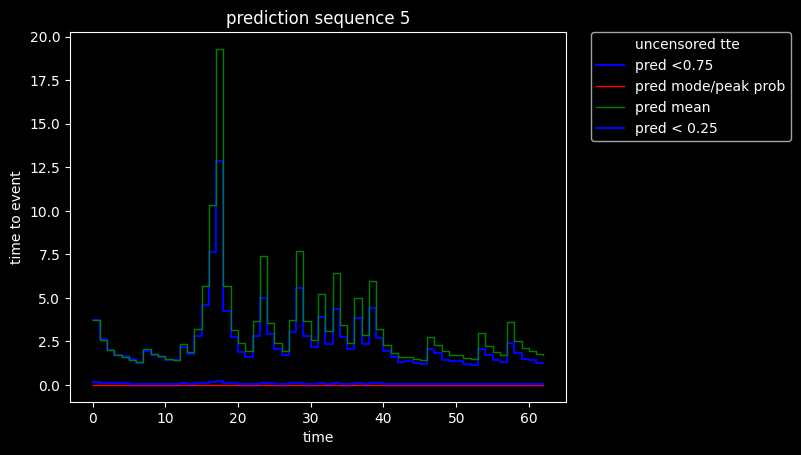

Good Example?:


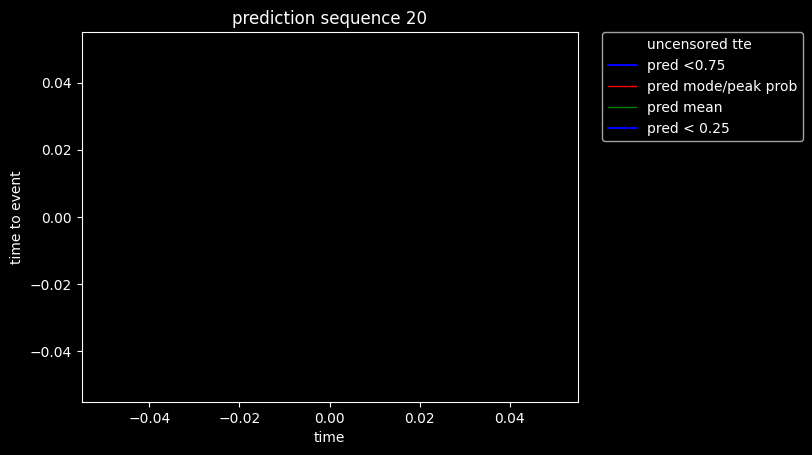

Good Example?:
alpha : mean    36.2250081623342
alpha : median  1.0939443707466125
alpha :    min  0.3990885019302368
alpha :    max  1079.5152587890625
beta  : mean    0.46792619658281226
beta  : median  0.4350426495075226
beta  :    min  0.286029577255249
beta  :    max  0.9684735536575317


In [10]:
# Optional: add a margin of zeros at the end of the sequence to see what the 
# model does after the first events (if it identifies death by pushing prediction to inf)
mask = np.copy(x_test)
mask[mask == mask_value] = np.nan
mask = mask*0
predicted = model.predict(x_test)+mask[:, :, :1]
alpha_flat = predicted[:, :, 0][~np.isnan(predicted[:, :, 0])].flatten()
beta_flat  = predicted[:, :, 1][~np.isnan(predicted[:, :, 0])].flatten()
## log-alpha typically makes more sense.
from matplotlib.colors import LogNorm
counts, xedges, yedges, _ = plt.hist2d(alpha_flat, beta_flat,
                                       bins=50, norm=LogNorm())
plt.title('Predicted params : density')
plt.xlim([alpha_flat.min(), alpha_flat.max()])
plt.ylim([beta_flat.min(), beta_flat.max()])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.show()
# Pick out prediction for one sequence
batch_indx = 500
print('Bad Example?:')
for batch_indx in [5, 20]:
    seq_len = (~np.isnan(predicted[batch_indx, :, 0])).sum()
    a = predicted[batch_indx, :seq_len, 0] + mask[batch_indx, :seq_len, 0]
    b = predicted[batch_indx, :seq_len, 1] + mask[batch_indx, :seq_len, 0]
    t = np.array(xrange(len(a))) + mask[batch_indx, :seq_len, 0]
    tte_actual = y_test[batch_indx, :seq_len, 0] + mask[batch_indx, :seq_len, 0]
    ##### Prediction (Using weibull-quantities like quantiles etc)
    drawstyle = 'steps-post'
    plt.plot(t,tte_actual, label='uncensored tte', color='black',
             linestyle='solid', linewidth=2, drawstyle=drawstyle)
    plt.plot(weibull.quantiles(a, b, 0.75), color='blue', label='pred <0.75',
             drawstyle=drawstyle)
    plt.plot(weibull.mode(a, b), color='red', linewidth=1,
             label='pred mode/peak prob', drawstyle=drawstyle)
    plt.plot(weibull.mean(a, b), color='green', linewidth=1,
             label='pred mean', drawstyle='steps-post')
    plt.plot(weibull.quantiles(a, b, 0.25), color='blue',
             label='pred < 0.25', drawstyle=drawstyle)
    #     plt.ylim(0, 2*np.nanmax(tte_actual))
    plt.xlabel('time')
    plt.ylabel('time to event')
    plt.title('prediction sequence '+str(batch_indx),)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    print('Good Example?:')

print('alpha : mean   ',alpha_flat.mean())
print('alpha : median ',np.median(alpha_flat))
print('alpha :    min ',alpha_flat.min())
print('alpha :    max ',alpha_flat.max())
print('beta  : mean   ',beta_flat.mean())
print('beta  : median ',np.median(beta_flat))
print('beta  :    min ',beta_flat.min())
print('beta  :    max ',beta_flat.max())

# Analysis

- The model is trained on alive and dead sequences. 
- At every step it's trying to predict tte
- It's *also* trying to predict if the sequence is dying or not i.e inifinity TTE (i.e prediction spiking to infinity)
- Very high prediction may be a feature (if were trying to identify churners), a bug (if it learns the censoring point in the dataset i.e artifact learning) or both (we want it to spike if it's a changepoint but we dont want it to spike only due to censoring or that it causes instability and numerical problems. 
- There's some pretty effective remedies for a middleway that I'll post soon
- For application to a real dataset check out `data-pipeline-template`